# Transfer Learning in NLP


In this notebook, we will go through basics of Transfer Learning in NLP using two architectures (pretrained models) CoVe and BERT and also compare the results of custom embeddings on LSTM, BiLSTM, GRU with CoVe and BERT on [Twitter US Airline Sentiment dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment).

### Dataset

Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").  It contains whether the sentiment of the tweets in this set was positive, neutral, or negative for six US airlines


Here we will use [keras](https://keras.io/  "Keras Homepage").


Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/nlp/transfer/learning/2019/02/22/Power-of-Transfer-Learning-in-NLP/). This is notebook which replicates the result of blog and runs in colab. Enjoy!

#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/tl_nlp/tl_nlp_keras.ipynb)

### Results

|  Approach | Epoch  | Time (sec)  | Train Accuracy(%)  | Dev Accuracy (%)  |
|---|---|---|---|---|
| LSTM  |  10  | 250  |  82 |  80 |
| BiLSTM |  10 |  500 |  83 | 79  |
| GRU  |  10 |  300 |  88 | 77  |
| CoVe  | 10 | 450  | 72  | 72  |
| BERT  |  3 | 500  |  - | 85  |



## Download data and pretrained models

In [0]:
# ! wget "http://nlp.stanford.edu/data/glove.840B.300d.zip"
# ! unzip -q -n "glove.840B.300d.zip"

In [0]:
! wget "http://nlp.stanford.edu/data/glove.6B.zip"
! unzip -q -n "glove.6B.zip"

--2019-03-24 23:55:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2019-03-24 23:55:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  12.0MB/s    in 1m 44s  

2019-03-24 23:56:50 (7.90 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [0]:
! python -m spacy download en
! python -m spacy download en_core_web_md


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')

    100% |████████████████████████████████| 120.9MB 52.0MB/s 
  Running setup.py install for en-core-web-md ... done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_md -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_md

    You can now load the model via spacy.load('en_core_web_md')



In [0]:
!wget https://raw.githubusercontent.com/dipanjanS/practical-machine-learning-with-python/master/bonus%20content/nlp%20proven%20approach/contractions.py

--2019-03-27 17:29:21--  https://raw.githubusercontent.com/dipanjanS/practical-machine-learning-with-python/master/bonus%20content/nlp%20proven%20approach/contractions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3052 (3.0K) [text/plain]
Saving to: ‘contractions.py’

contractions.py     100%[===================>]   2.98K  --.-KB/s    in 0s      

2019-03-27 17:29:22 (47.5 MB/s) - ‘contractions.py’ saved [3052/3052]



## Tweets Sentiment data

Code Adapted from : [Link](https://github.com/google-research/bert/blob/master/run_classifier.py)

Pretrained Model : [Link](https://github.com/google-research/bert#pre-trained-models)

Paper BERT : [Link](https://arxiv.org/pdf/1810.04805.pdf)


In [0]:
from pathlib import Path
import pandas as pd
import numpy as np
import re
import time
import spacy
import nltk
import os
import datetime
from tqdm import tqdm
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM, Embedding, Dense, Input, CuDNNLSTM, GRU, CuDNNGRU, Bidirectional
from keras.models import Model, load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from keras.utils import to_categorical
path = Path("data")
from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline


nlp = spacy.load('en', parse=True, tag=True, entity=True)
tokenizer = ToktokTokenizer()
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
data = pd.read_csv('https://query.data.world/s/hus7zihvuo5vt65cnv4fcfn2ppfj6y', encoding = "ISO-8859-1")
data.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


In [0]:
print (data.shape)

(14640, 20)


## Exploratory data analysis

In [0]:
print (data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 20 columns):
_unit_id                        14640 non-null int64
_golden                         14640 non-null bool
_unit_state                     14640 non-null object
_trusted_judgments              14640 non-null int64
_last_judgment_at               14584 non-null object
airline_sentiment               14640 non-null object
airline_sentiment:confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason:confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 

In [0]:
data.describe(include='all')

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
count,1.464000e+04,14640,14640,14640.000000,14584,14640,14640.000000,9178,10522.000000,14640,40,14640,32,14640.000000,14640,1019,14640,1.464000e+04,9907,9820
unique,NaN,2,3,NaN,648,3,NaN,10,NaN,6,3,7701,13,NaN,14427,832,6804,NaN,3081,85
top,NaN,False,finalized,NaN,2/25/15 19:11,negative,NaN,Customer Service Issue,NaN,United,negative,JetBlueNews,Customer Service Issue,NaN,@united thanks,"[0.0, 0.0]",2/22/15 17:15,NaN,"Boston, MA",Eastern Time (US & Canada)
freq,NaN,14600,14583,NaN,101,9178,NaN,2910,NaN,3822,32,63,12,NaN,6,164,11,NaN,157,3744
mean,6.814957e+08,NaN,NaN,3.618648,NaN,NaN,0.900169,NaN,0.638298,NaN,NaN,NaN,NaN,0.082650,NaN,NaN,NaN,5.692184e+17,NaN,NaN
std,8.504314e+04,NaN,NaN,11.858704,NaN,NaN,0.162830,NaN,0.330440,NaN,NaN,NaN,NaN,0.745778,NaN,NaN,NaN,7.791092e+14,NaN,NaN
min,6.814482e+08,NaN,NaN,2.000000,NaN,NaN,0.335000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,5.675880e+17,NaN,NaN
25%,6.814536e+08,NaN,NaN,3.000000,NaN,NaN,0.692300,NaN,0.360600,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,5.685590e+17,NaN,NaN
50%,6.814578e+08,NaN,NaN,3.000000,NaN,NaN,1.000000,NaN,0.670600,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,5.694780e+17,NaN,NaN
75%,6.814623e+08,NaN,NaN,3.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,5.698902e+17,NaN,NaN


United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64


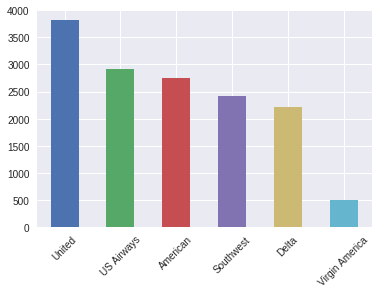

In [0]:
# Number of tweets per airline
 
airline_count = data['airline'].sort_index().value_counts()
print (airline_count)
airline_count.plot(kind='bar',rot=45)
plt.show()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


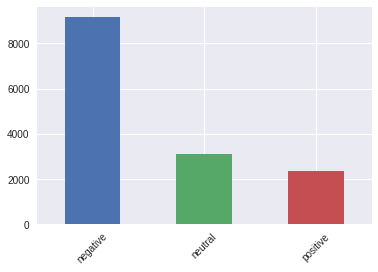

In [0]:
# distribution of sentiments 

sentiment_count = data['airline_sentiment'].sort_index().value_counts()
print (sentiment_count)
sentiment_count.plot(kind='bar',rot=45)
plt.show()

airline         airline_sentiment
American        negative             1960
                neutral               463
                positive              336
Delta           negative              955
                neutral               723
                positive              544
Southwest       negative             1186
                neutral               664
                positive              570
US Airways      negative             2263
                neutral               381
                positive              269
United          negative             2633
                neutral               697
                positive              492
Virgin America  negative              181
                neutral               171
                positive              152
Name: airline_sentiment, dtype: int64


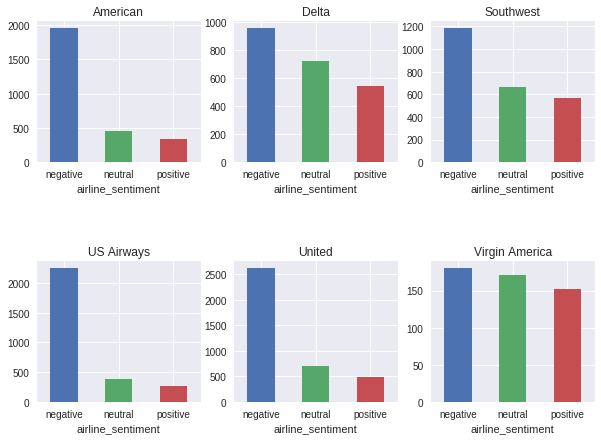

In [0]:
# distribution of sentiments per airline

dist_count = data.groupby('airline')['airline_sentiment'].value_counts()
print (dist_count)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
fig.subplots_adjust(hspace=0.7)
#, 'US Airways', 'United', 'Virgin America'
j = 0
i = 0
for airline in ['American', 'Delta', 'Southwest', 'US Airways', 'United', 'Virgin America']:
  dist_count[airline].plot(ax=axes[i][j], kind='bar', use_index=True, rot=0, title=airline)
  j += 1
  if j == 3: i=1; j=0

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64


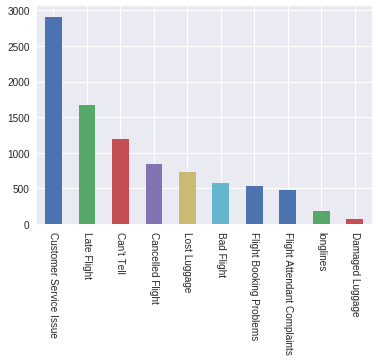

In [0]:
# distribution of reasons

reasons_count = data['negativereason'].sort_index().value_counts()
print (reasons_count)
reasons_count.plot(kind='bar',rot=270)
plt.show()

airline         airline         user_timezone             
American        American        Eastern Time (US & Canada)    535
Delta           Delta           Eastern Time (US & Canada)    835
Southwest       Southwest       Central Time (US & Canada)    497
US Airways      US Airways      Eastern Time (US & Canada)    898
United          United          Eastern Time (US & Canada)    886
Virgin America  Virgin America  Pacific Time (US & Canada)    126
Name: user_timezone, dtype: int64


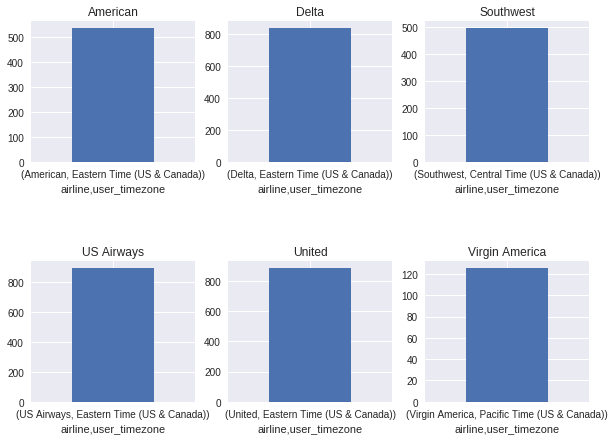

In [0]:
# topmost timezones with most number of tweets in each airlines

timezone_count = data.groupby('airline')['user_timezone'].value_counts()
timezone_count = timezone_count.groupby(level=[0]).nlargest(1)
print (timezone_count)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
fig.subplots_adjust(hspace=0.7)
#, 'US Airways', 'United', 'Virgin America'
j = 0
i = 0
for airline in ['American', 'Delta', 'Southwest', 'US Airways', 'United', 'Virgin America']:
  timezone_count[airline].plot(ax=axes[i][j], kind='bar', use_index=True, rot=0, title=airline)
  j += 1
  if j == 3: i=1; j=0

In [0]:
#visualization using wordcloud for the negative tweets

def visualize_wordcloud(sentiment):
  
    df = data[data['airline_sentiment']==sentiment]
    words = ' '.join(df['text'])
    cleaned_word = " ".join([word for word in words.split()
                                if 'http' not in word
                                    and not word.startswith('@')
                                    and word != 'RT'])

    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='black',
                          width=3000,
                          height=2500
                         ).generate(cleaned_word)


    plt.figure(1,figsize=(12, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

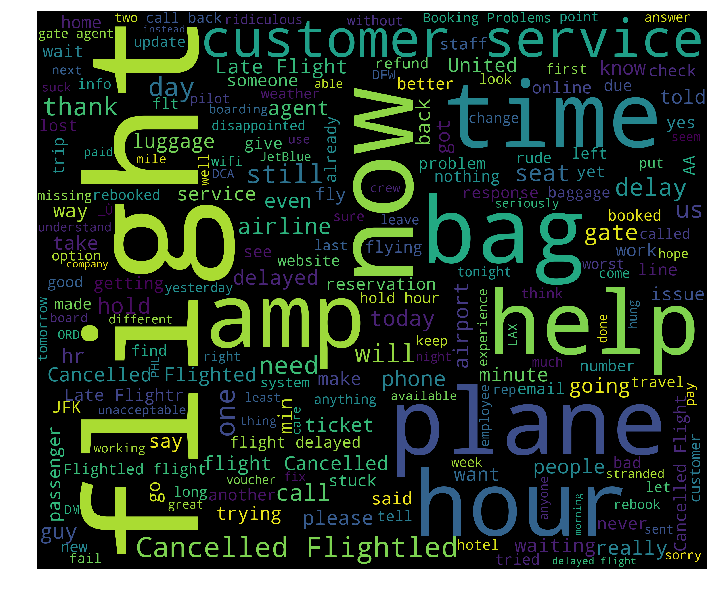

In [0]:
visualize_wordcloud('negative')

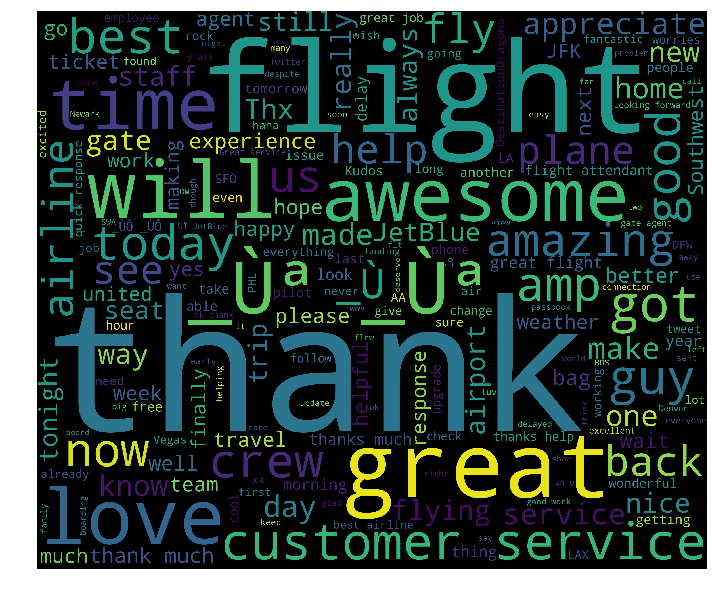

In [0]:
visualize_wordcloud('positive')

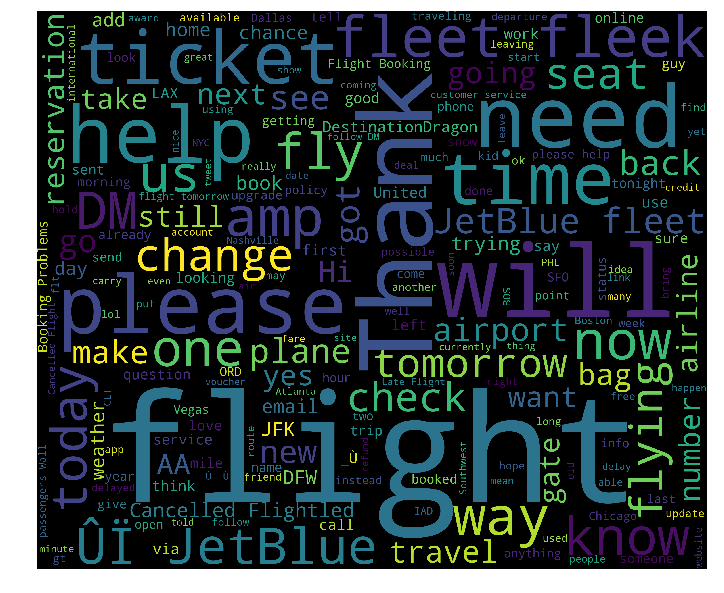

In [0]:
visualize_wordcloud('neutral')

## Preprocessing Text

In [0]:
def preprocess_text(text):
    
    #strip html tags
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    
    #remove accented characters
    new_text = unicodedata.normalize('NFKD', stripped_text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    #expand contractions
    expanded_text = expand_contractions(new_text)
    
    #remove special characters and digits
    pattern = r'[^a-zA-z0-9\s]'
    no_sc_text = re.sub(pattern, '', expanded_text)
    
    #stemming
    ps = nltk.porter.PorterStemmer()
    stem_text = ' '.join([ps.stem(word) for word in no_sc_text.split()])
    
    
    #lemmatization
    nlp_text = nlp(stem_text)
    lemma_text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in nlp_text])
    
    
    #remove stopwords
    filtered_text = remove_stopwords(lemma_text)
    
    
    return filtered_text

In [0]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [0]:
def remove_stopwords(text, is_lower_case=False):
    
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    
    return filtered_text

In [0]:
start = time.time()

preprocessed_text = []
for i in tqdm(range(len(data))):  
    preprocessed_text.append(preprocess_text(data['text'][i]))
  
print ('Preprocessing took {:.2f} seconds'.format(time.time()-start))  

100%|██████████| 14640/14640 [05:13<00:00, 46.65it/s]

Preprocessing took 313.82 seconds


In [0]:
print ('Before preprocessing:')
print (data['text'].values[:5])

Before preprocessing:
['@VirginAmerica What @dhepburn said.'
 "@VirginAmerica plus you've added commercials to the experience... tacky."
 "@VirginAmerica I didn't today... Must mean I need to take another trip!"
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'
 "@VirginAmerica and it's a really big bad thing about it"]


In [0]:
print ('After preprocessing:')
print (preprocessed_text[:5])

After preprocessing:
['virginamerica dhepburn say', 'virginamerica plu ad commerci experi tacki', 'virginamerica not today must mean need take anoth trip', 'virginamerica realli aggress blast obnoxi entertain guest face littl recour', 'virginamerica realli big bad thing']


In [0]:
NUM_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100

# convert each word into token(integer) with maximum number of words based on frequency is 20000
tokenizer = Tokenizer(num_words=NUM_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'', lower=True)
tokenizer.fit_on_texts(preprocessed_text)

# stitch back the words into sequences with filtering symbols and converting to lower
sequences = tokenizer.texts_to_sequences(preprocessed_text)
# convert all sentences to equal length of 100
sentences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13851 unique tokens.


## Custom Embedding Layer using LSTM

In [0]:
labels = data['airline_sentiment'].values
lb = LabelEncoder()
labels = lb.fit_transform(labels)

X, Y = sentences, labels

train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.2, stratify=Y)

train_y = to_categorical(train_y, num_classes=3)
val_y = to_categorical(val_y, num_classes=3)

print ('Training:', train_x.shape, train_y.shape)
print ('Validation:', val_x.shape, val_y.shape)

Training: (11712, 100) (11712, 3)
Validation: (2928, 100) (2928, 3)


In [0]:
num_classes = 3
EMBED_DIM = 300
VOCAB_SIZE = min(len(word_index)+1, NUM_WORDS)

# input layer with shape = (MAX_SEQUENCE_LENGTH,)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# convert the sequence input to embedding from (MAX_SEQUENCE_LENGTH, ) -> (VOCAB_SIZE, EMBEDDING_DIM)
embedded_sequences = Embedding(VOCAB_SIZE, EMBED_DIM)(sequence_input)

x = LSTM(256, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)(embedded_sequences)
x = LSTM(128, dropout=0.5, recurrent_dropout=0.5)(x)
preds = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=preds)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 300)          4155600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 256)          570368    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 4,923,475
Trainable params: 4,923,475
Non-trainable params: 0
___________

In [0]:
es = EarlyStopping(monitor='val_acc', patience=3, verbose=1)

In [0]:
history = model.fit(train_x, train_y,
                    batch_size=128,
                    epochs=10,
                    validation_data=(val_x, val_y),
                    callbacks = [es])

Instructions for updating:
Use tf.cast instead.
Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 50s 4ms/step - loss: 0.7346 - acc: 0.6882 - val_loss: 0.5749 - val_acc: 0.7664
Epoch 2/10
11712/11712 [==============================] - 47s 4ms/step - loss: 0.4656 - acc: 0.8154 - val_loss: 0.5199 - val_acc: 0.7995
Epoch 3/10
11712/11712 [==============================] - 47s 4ms/step - loss: 0.3413 - acc: 0.8729 - val_loss: 0.5586 - val_acc: 0.7886
Epoch 4/10
11712/11712 [==============================] - 47s 4ms/step - loss: 0.2610 - acc: 0.9063 - val_loss: 0.6025 - val_acc: 0.7906
Epoch 5/10
11712/11712 [==============================] - 47s 4ms/step - loss: 0.2077 - acc: 0.9270 - val_loss: 0.6568 - val_acc: 0.7886
Epoch 00005: early stopping


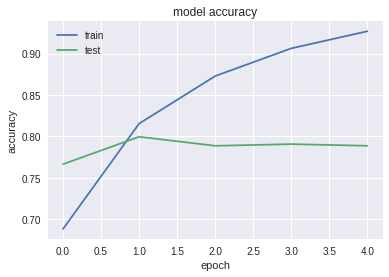

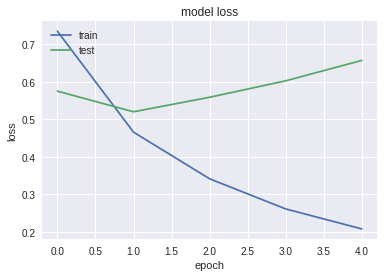

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Custom Embedding Layer using BiLSTM

In [0]:
labels = data['airline_sentiment'].values
lb = LabelEncoder()
labels = lb.fit_transform(labels)

X, Y = sentences, labels

train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.2, stratify=Y)

train_y = to_categorical(train_y, num_classes=3)
val_y = to_categorical(val_y, num_classes=3)

print ('Training:', train_x.shape, train_y.shape)
print ('Validation:', val_x.shape, val_y.shape)

Training: (11712, 100) (11712, 3)
Validation: (2928, 100) (2928, 3)


In [0]:
num_classes = 3
EMBED_DIM = 300
VOCAB_SIZE = min(len(word_index)+1, NUM_WORDS)

# input layer with shape = (MAX_SEQUENCE_LENGTH,)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# convert the sequence input to embedding from (MAX_SEQUENCE_LENGTH, ) -> (VOCAB_SIZE, EMBEDDING_DIM)
embedded_sequences = Embedding(VOCAB_SIZE, EMBED_DIM)(sequence_input)

x = Bidirectional(LSTM(256, dropout=0.4, recurrent_dropout=0.4, return_sequences=True))(embedded_sequences)
x = Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.5))(x)
preds = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=preds)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 300)          4155600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 512)          1140736   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               656384    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 5,953,491
Trainable params: 5,953,491
Non-trainable params: 0
_________________________________________________________________


In [0]:
es = EarlyStopping(monitor='val_acc', patience=3, verbose=1)

In [0]:
history = model.fit(train_x, train_y,
                    batch_size=128,
                    epochs=10,
                    validation_data=(val_x, val_y),
                    callbacks = [es])

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 102s 9ms/step - loss: 0.7153 - acc: 0.6978 - val_loss: 0.5624 - val_acc: 0.7705
Epoch 2/10
11712/11712 [==============================] - 98s 8ms/step - loss: 0.4380 - acc: 0.8315 - val_loss: 0.5317 - val_acc: 0.7906
Epoch 3/10
11712/11712 [==============================] - 99s 8ms/step - loss: 0.3000 - acc: 0.8934 - val_loss: 0.5757 - val_acc: 0.7869
Epoch 4/10
11712/11712 [==============================] - 99s 8ms/step - loss: 0.2151 - acc: 0.9254 - val_loss: 0.6547 - val_acc: 0.7753
Epoch 5/10
11712/11712 [==============================] - 98s 8ms/step - loss: 0.1743 - acc: 0.9407 - val_loss: 0.7527 - val_acc: 0.7773
Epoch 00005: early stopping


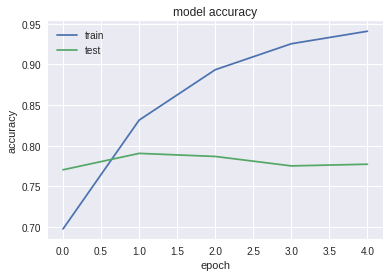

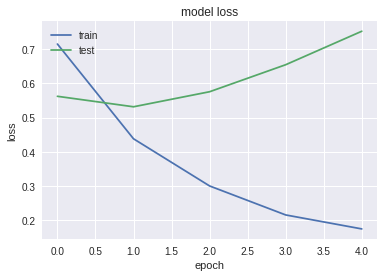

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Custom Embedding Layer using GRU

In [0]:
labels = data['airline_sentiment'].values
lb = LabelEncoder()
labels = lb.fit_transform(labels)

X, Y = sentences, labels

train_x, val_x, train_y, val_y = train_test_split(X, Y, test_size=0.2, stratify=Y)

train_y = to_categorical(train_y, num_classes=3)
val_y = to_categorical(val_y, num_classes=3)

print ('Training:', train_x.shape, train_y.shape)
print ('Validation:', val_x.shape, val_y.shape)

Training: (11712, 100) (11712, 3)
Validation: (2928, 100) (2928, 3)


In [0]:
num_classes = 3
EMBED_DIM = 300
VOCAB_SIZE = min(len(word_index)+1, NUM_WORDS)

# input layer with shape = (MAX_SEQUENCE_LENGTH,)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# convert the sequence input to embedding from (MAX_SEQUENCE_LENGTH, ) -> (VOCAB_SIZE, EMBEDDING_DIM)
embedded_sequences = Embedding(VOCAB_SIZE, EMBED_DIM)(sequence_input)

x = GRU(256, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)(embedded_sequences)
x = GRU(128, dropout=0.5, recurrent_dropout=0.5)(x)
preds = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=preds)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 300)          4155600   
_________________________________________________________________
gru_1 (GRU)                  (None, 100, 256)          427776    
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               147840    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 4,731,603
Trainable params: 4,731,603
Non-trainable params: 0
_________________________________________________________________


In [0]:
es = EarlyStopping(monitor='val_acc', patience=3, verbose=1)

In [0]:
history = model.fit(train_x, train_y,
                    batch_size=128,
                    epochs=10,
                    validation_data=(val_x, val_y),
                    callbacks = [es])

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 43s 4ms/step - loss: 0.6915 - acc: 0.7126 - val_loss: 0.5566 - val_acc: 0.7712
Epoch 2/10
11712/11712 [==============================] - 39s 3ms/step - loss: 0.4358 - acc: 0.8315 - val_loss: 0.5810 - val_acc: 0.7770
Epoch 3/10
11712/11712 [==============================] - 39s 3ms/step - loss: 0.3141 - acc: 0.8871 - val_loss: 0.5811 - val_acc: 0.7773
Epoch 4/10
11712/11712 [==============================] - 40s 3ms/step - loss: 0.2379 - acc: 0.9150 - val_loss: 0.6903 - val_acc: 0.7732
Epoch 5/10
11712/11712 [==============================] - 40s 3ms/step - loss: 0.1921 - acc: 0.9331 - val_loss: 0.7160 - val_acc: 0.7684
Epoch 6/10
11712/11712 [==============================] - 40s 3ms/step - loss: 0.1565 - acc: 0.9479 - val_loss: 0.8405 - val_acc: 0.7613
Epoch 00006: early stopping


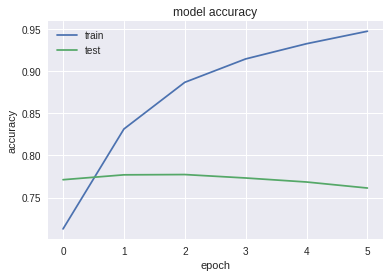

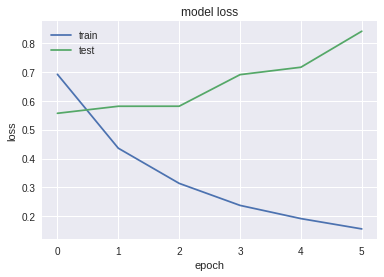

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Transfer Learning in NLP

## CoVe

Paper: [Link]()

Pretrained Weights from: [Link](https://github.com/kylejshaffer/CoVe)

In [0]:
#get pretrained CoVe model
!wget raw.githubusercontent.com/kylejshaffer/CoVe/master/Keras_CoVe_py36.h5

URL transformed to HTTPS due to an HSTS policy
--2019-03-25 00:35:26--  https://raw.githubusercontent.com/kylejshaffer/CoVe/master/Keras_CoVe_py36.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14441952 (14M) [application/octet-stream]
Saving to: ‘Keras_CoVe_py36.h5’

Keras_CoVe_py36.h5  100%[===================>]  13.77M  86.9MB/s    in 0.2s    

2019-03-25 00:35:27 (86.9 MB/s) - ‘Keras_CoVe_py36.h5’ saved [14441952/14441952]



In [0]:
cove_model = load_model('Keras_CoVe_py36.h5')
print (cove_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 300)    0                                            
__________________________________________________________________________________________________
masking_2 (Masking)             (None, None, 300)    0           input_1[0][0]                    
__________________________________________________________________________________________________
bidir_1 (Bidirectional)         (None, None, 600)    1442400     masking_2[0][0]                  
__________________________________________________________________________________________________
bidir_2 (Bidirectional)         (None, None, 600)    2162400     bidir_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [0]:
from gensim.scripts.glove2word2vec import glove2word2vec

# to convert the GloVe file format to the word2vec file format
glove_input_file = 'glove.6B.300d.txt' #'glove.840B.300d.txt'
word2vec_output_file = 'glove.6B.300d.txt.word2vec' #'glove.840B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 300)

In [0]:
from gensim.models import KeyedVectors

#%time word_vectors = KeyedVectors.load_word2vec_format('/content/glove.840B.300d.txt.word2vec', binary=False)
%time word_vectors = KeyedVectors.load_word2vec_format('/content/glove.6B.300d.txt.word2vec', binary=False)

CPU times: user 1min 46s, sys: 1.48 s, total: 1min 48s
Wall time: 1min 48s


In [0]:
EMBEDDING_DIM = 300
VOCAB_SIZE = min(len(word_index)+1, NUM_WORDS)
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, i in word_index.items():
  
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
        
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25), EMBEDDING_DIM)

del(word_vectors)

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(VOCAB_SIZE,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [0]:
labels = data['airline_sentiment'].values
lb = LabelEncoder()
labels = lb.fit_transform(labels)

X, Y = sentences, labels
print (X.shape, Y.shape)

(14640, 100) (14640,)


In [0]:
# input layer with shape = (MAX_SEQUENCE_LENGTH,)
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
# convert the sequence input to embedding from (MAX_SEQUENCE_LENGTH, ) -> (VOCAB_SIZE, EMBEDDING_DIM)
embedded_sequences = embedding_layer(sequence_input)

glove_model = Model(inputs=sequence_input, outputs=embedded_sequences)
print (glove_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 300)          4155600   
Total params: 4,155,600
Trainable params: 0
Non-trainable params: 4,155,600
_________________________________________________________________
None


In [0]:
cove_inp = glove_model.predict(X)

In [0]:
cove_output = cove_model.predict(cove_inp)
print (cove_output.shape)

(14640, 100, 600)


In [0]:
train_x, val_x, train_y, val_y = train_test_split(cove_output, Y, test_size=0.2, stratify=Y)

train_y = to_categorical(train_y, num_classes=3)
val_y = to_categorical(val_y, num_classes=3)

print ('Training:', train_x.shape, train_y.shape)
print ('Validation:', val_x.shape, val_y.shape)

Training: (11712, 100, 600) (11712, 3)
Validation: (2928, 100, 600) (2928, 3)


In [0]:
num_classes = 3
MAX_LEN = 100
EMBEDDING_DIM = 600

# input layer with shape = (MAX_LEN, EMBEDDING_DIM,)
sequence_input = Input(shape=(MAX_LEN, EMBEDDING_DIM,), dtype='float32')

x = LSTM(256, dropout=0.4, recurrent_dropout=0.4, return_sequences=True)(sequence_input)
x = LSTM(128, dropout=0.5, recurrent_dropout=0.5)(x)
preds = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=sequence_input, outputs=preds)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 100, 600)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 256)          877568    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 1,075,075
Trainable params: 1,075,075
Non-trainable params: 0
_________________________________________________________________


In [0]:
es = EarlyStopping(monitor='val_acc', patience=3, verbose=1)

In [0]:
history = model.fit(train_x, train_y,
                    batch_size=128,
                    epochs=10,
                    validation_data=(val_x, val_y),
                    callbacks = [es])

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 49s 4ms/step - loss: 0.8250 - acc: 0.6517 - val_loss: 0.7669 - val_acc: 0.6568
Epoch 2/10
11712/11712 [==============================] - 47s 4ms/step - loss: 0.7485 - acc: 0.6907 - val_loss: 0.7326 - val_acc: 0.6995
Epoch 3/10
11712/11712 [==============================] - 47s 4ms/step - loss: 0.7362 - acc: 0.7003 - val_loss: 0.6966 - val_acc: 0.7141
Epoch 4/10
11712/11712 [==============================] - 48s 4ms/step - loss: 0.7081 - acc: 0.7138 - val_loss: 0.6787 - val_acc: 0.7179
Epoch 5/10
11712/11712 [==============================] - 48s 4ms/step - loss: 0.6946 - acc: 0.7163 - val_loss: 0.6792 - val_acc: 0.7251
Epoch 6/10
11712/11712 [==============================] - 55s 5ms/step - loss: 0.6843 - acc: 0.7226 - val_loss: 0.6811 - val_acc: 0.7097
Epoch 7/10
11712/11712 [==============================] - 47s 4ms/step - loss: 0.6804 - acc: 0.7171 - val_loss: 0.6594 - val_acc:

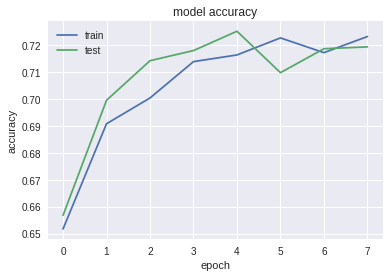

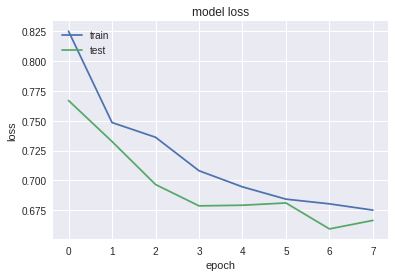

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## BERT

In [0]:
!git clone https://github.com/google-research/bert.git

Cloning into 'bert'...
remote: Enumerating objects: 320, done.
remote: Total 320 (delta 0), reused 0 (delta 0), pack-reused 320
Receiving objects: 100% (320/320), 258.38 KiB | 7.38 MiB/s, done.
Resolving deltas: 100% (180/180), done.


Download the pre-trained model from official BERT Github page [here](https://github.com/google-research/bert#pre-trained-models).

In [0]:
! wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
! unzip uncased_L-12_H-768_A-12.zip

! wget https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip
! unzip cased_L-12_H-768_A-12.zip

--2019-03-27 17:29:37--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip’

uncased_L-12_H-768_ 100%[===================>] 388.84M  95.0MB/s    in 4.1s    

2019-03-27 17:29:42 (95.0 MB/s) - ‘uncased_L-12_H-768_A-12.zip’ saved [407727028/407727028]

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  
--2019-03-27 1

### Preparing Data for BERT

We need to prepare the text data in a format that it complies with BERT model. Basically codes written by Google to apply BERT accepts the “Tab separated” file in following format.

train.tsv or dev.tsv

an ID for the row
the label for the row as an int (class labels: 0,1,2,3 etc)
A column of all the same letter (weird throw away column expected by BERT)
the text examples you want to classify
test.tsv

an ID for the row
the text sentences/paragraph you want to test

In [0]:
import pandas as pd

df = pd.read_csv('https://query.data.world/s/hus7zihvuo5vt65cnv4fcfn2ppfj6y', encoding = "ISO-8859-1")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


In [0]:
os.mkdir('data')
df.to_csv('data/train.csv', index=False)

In [0]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from pandas import DataFrame
 
le = LabelEncoder()
 
df = pd.read_csv("data/train.csv")

# Creating train and dev dataframes according to BERT
df_bert = pd.DataFrame({'user_id': df['_unit_id'],
            'label': le.fit_transform(df['airline_sentiment']),
            'alpha': ['a'] * df.shape[0],
            'text': df['text'].replace(r'\n',' ',regex=True)})

df_bert_train, df_bert_dev = train_test_split(df_bert, test_size=0.01)
  
cols = ['user_id', 'label', 'alpha', 'text']
     
# # Creating test dataframe according to BERT
# df_test = pd.read_csv("data/test.csv")
# df_bert_test = pd.DataFrame({'User_ID': df_test['_unit_id'],
#                  'text': df_test['text']})
 
# Saving dataframes to .tsv format as required by BERT
df_bert_train[cols].to_csv('data/train.tsv', sep='\t', index=False, header=False)
df_bert_dev[cols].to_csv('data/dev.tsv', sep='\t', index=False, header=False)
df_bert_dev[cols].to_csv('data/test.tsv', sep='\t', index=False, header=False)

In [0]:
# !cat bert/run_classifier.py

In [0]:
% cd bert

/content/bert


In [0]:
%%writefile bert_classifier.py
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""BERT finetuning runner."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import csv
import os
import modeling
import optimization
import tokenization
import tensorflow as tf

flags = tf.flags

FLAGS = flags.FLAGS

## Required parameters
flags.DEFINE_string(
    "data_dir", None,
    "The input data dir. Should contain the .tsv files (or other data files) "
    "for the task.")

flags.DEFINE_string(
    "bert_config_file", None,
    "The config json file corresponding to the pre-trained BERT model. "
    "This specifies the model architecture.")

flags.DEFINE_string("task_name", None, "The name of the task to train.")

flags.DEFINE_string("vocab_file", None,
                    "The vocabulary file that the BERT model was trained on.")

flags.DEFINE_string(
    "output_dir", None,
    "The output directory where the model checkpoints will be written.")

## Other parameters

flags.DEFINE_string(
    "init_checkpoint", None,
    "Initial checkpoint (usually from a pre-trained BERT model).")

flags.DEFINE_bool(
    "do_lower_case", True,
    "Whether to lower case the input text. Should be True for uncased "
    "models and False for cased models.")

flags.DEFINE_integer(
    "max_seq_length", 128,
    "The maximum total input sequence length after WordPiece tokenization. "
    "Sequences longer than this will be truncated, and sequences shorter "
    "than this will be padded.")

flags.DEFINE_bool("do_train", False, "Whether to run training.")

flags.DEFINE_bool("do_eval", False, "Whether to run eval on the dev set.")

flags.DEFINE_bool(
    "do_predict", False,
    "Whether to run the model in inference mode on the test set.")

flags.DEFINE_integer("train_batch_size", 32, "Total batch size for training.")

flags.DEFINE_integer("eval_batch_size", 8, "Total batch size for eval.")

flags.DEFINE_integer("predict_batch_size", 8, "Total batch size for predict.")

flags.DEFINE_float("learning_rate", 5e-5, "The initial learning rate for Adam.")

flags.DEFINE_float("num_train_epochs", 3.0,
                   "Total number of training epochs to perform.")

flags.DEFINE_float(
    "warmup_proportion", 0.1,
    "Proportion of training to perform linear learning rate warmup for. "
    "E.g., 0.1 = 10% of training.")

flags.DEFINE_integer("save_checkpoints_steps", 1000,
                     "How often to save the model checkpoint.")

flags.DEFINE_integer("iterations_per_loop", 1000,
                     "How many steps to make in each estimator call.")

flags.DEFINE_bool("use_tpu", False, "Whether to use TPU or GPU/CPU.")

tf.flags.DEFINE_string(
    "tpu_name", None,
    "The Cloud TPU to use for training. This should be either the name "
    "used when creating the Cloud TPU, or a grpc://ip.address.of.tpu:8470 "
    "url.")

tf.flags.DEFINE_string(
    "tpu_zone", None,
    "[Optional] GCE zone where the Cloud TPU is located in. If not "
    "specified, we will attempt to automatically detect the GCE project from "
    "metadata.")

tf.flags.DEFINE_string(
    "gcp_project", None,
    "[Optional] Project name for the Cloud TPU-enabled project. If not "
    "specified, we will attempt to automatically detect the GCE project from "
    "metadata.")

tf.flags.DEFINE_string("master", None, "[Optional] TensorFlow master URL.")

flags.DEFINE_integer(
    "num_tpu_cores", 8,
    "Only used if `use_tpu` is True. Total number of TPU cores to use.")


class InputExample(object):
  """A single training/test example for simple sequence classification."""

  def __init__(self, guid, text_a, text_b=None, label=None):
    """Constructs a InputExample.

    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
    self.guid = guid
    self.text_a = text_a
    self.text_b = text_b
    self.label = label


class PaddingInputExample(object):
  """Fake example so the num input examples is a multiple of the batch size.

  When running eval/predict on the TPU, we need to pad the number of examples
  to be a multiple of the batch size, because the TPU requires a fixed batch
  size. The alternative is to drop the last batch, which is bad because it means
  the entire output data won't be generated.

  We use this class instead of `None` because treating `None` as padding
  battches could cause silent errors.
  """


class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    self.is_real_example = is_real_example


class DataProcessor(object):
  """Base class for data converters for sequence classification data sets."""

  def get_train_examples(self, data_dir):
    """Gets a collection of `InputExample`s for the train set."""
    raise NotImplementedError()

  def get_dev_examples(self, data_dir):
    """Gets a collection of `InputExample`s for the dev set."""
    raise NotImplementedError()

  def get_test_examples(self, data_dir):
    """Gets a collection of `InputExample`s for prediction."""
    raise NotImplementedError()

  def get_labels(self):
    """Gets the list of labels for this data set."""
    raise NotImplementedError()

  @classmethod
  def _read_tsv(cls, input_file, quotechar=None):
    """Reads a tab separated value file."""
    with tf.gfile.Open(input_file, "r") as f:
      reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
      lines = []
      for line in reader:
        lines.append(line)
      return lines


class XnliProcessor(DataProcessor):
  """Processor for the XNLI data set."""

  def __init__(self):
    self.language = "zh"

  def get_train_examples(self, data_dir):
    """See base class."""
    lines = self._read_tsv(
        os.path.join(data_dir, "multinli",
                     "multinli.train.%s.tsv" % self.language))
    examples = []
    for (i, line) in enumerate(lines):
      if i == 0:
        continue
      guid = "train-%d" % (i)
      text_a = tokenization.convert_to_unicode(line[0])
      text_b = tokenization.convert_to_unicode(line[1])
      label = tokenization.convert_to_unicode(line[2])
      if label == tokenization.convert_to_unicode("contradictory"):
        label = tokenization.convert_to_unicode("contradiction")
      examples.append(
          InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    return examples

  def get_dev_examples(self, data_dir):
    """See base class."""
    lines = self._read_tsv(os.path.join(data_dir, "xnli.dev.tsv"))
    examples = []
    for (i, line) in enumerate(lines):
      if i == 0:
        continue
      guid = "dev-%d" % (i)
      language = tokenization.convert_to_unicode(line[0])
      if language != tokenization.convert_to_unicode(self.language):
        continue
      text_a = tokenization.convert_to_unicode(line[6])
      text_b = tokenization.convert_to_unicode(line[7])
      label = tokenization.convert_to_unicode(line[1])
      examples.append(
          InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    return examples

  def get_labels(self):
    """See base class."""
    return ["contradiction", "entailment", "neutral"]


class MnliProcessor(DataProcessor):
  """Processor for the MultiNLI data set (GLUE version)."""

  def get_train_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

  def get_dev_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "dev_matched.tsv")),
        "dev_matched")

  def get_test_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "test_matched.tsv")), "test")

  def get_labels(self):
    """See base class."""
    return ["contradiction", "entailment", "neutral"]

  def _create_examples(self, lines, set_type):
    """Creates examples for the training and dev sets."""
    examples = []
    for (i, line) in enumerate(lines):
      if i == 0:
        continue
      guid = "%s-%s" % (set_type, tokenization.convert_to_unicode(line[0]))
      text_a = tokenization.convert_to_unicode(line[8])
      text_b = tokenization.convert_to_unicode(line[9])
      if set_type == "test":
        label = "contradiction"
      else:
        label = tokenization.convert_to_unicode(line[-1])
      examples.append(
          InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    return examples


class MrpcProcessor(DataProcessor):
  """Processor for the MRPC data set (GLUE version)."""

  def get_train_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

  def get_dev_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

  def get_test_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

  def get_labels(self):
    """See base class."""
    return ["0", "1"]

  def _create_examples(self, lines, set_type):
    """Creates examples for the training and dev sets."""
    examples = []
    for (i, line) in enumerate(lines):
      if i == 0:
        continue
      guid = "%s-%s" % (set_type, i)
      text_a = tokenization.convert_to_unicode(line[3])
      text_b = tokenization.convert_to_unicode(line[4])
      if set_type == "test":
        label = "0"
      else:
        label = tokenization.convert_to_unicode(line[0])
      examples.append(
          InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
    return examples


class ColaProcessor(DataProcessor):
  """Processor for the CoLA data set (GLUE version)."""

  def get_train_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

  def get_dev_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

  def get_test_examples(self, data_dir):
    """See base class."""
    return self._create_examples(
        self._read_tsv(os.path.join(data_dir, "test.tsv")), "test")

  def get_labels(self):
    """See base class."""
    return ["0", "1", "2"]

  def _create_examples(self, lines, set_type):
    """Creates examples for the training and dev sets."""
    examples = []
    for (i, line) in enumerate(lines):
      # Only the test set has a header
      if set_type == "test" and i == 0:
        continue
      guid = "%s-%s" % (set_type, i)
      if set_type == "test":
        text_a = tokenization.convert_to_unicode(line[1])
        label = "0"
      else:
        text_a = tokenization.convert_to_unicode(line[3])
        label = tokenization.convert_to_unicode(line[1])
      examples.append(
          InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples


def convert_single_example(ex_index, example, label_list, max_seq_length,
                           tokenizer):
  """Converts a single `InputExample` into a single `InputFeatures`."""

  if isinstance(example, PaddingInputExample):
    return InputFeatures(
        input_ids=[0] * max_seq_length,
        input_mask=[0] * max_seq_length,
        segment_ids=[0] * max_seq_length,
        label_id=0,
        is_real_example=False)

  label_map = {}
  for (i, label) in enumerate(label_list):
    label_map[label] = i

  tokens_a = tokenizer.tokenize(example.text_a)
  tokens_b = None
  if example.text_b:
    tokens_b = tokenizer.tokenize(example.text_b)

  if tokens_b:
    # Modifies `tokens_a` and `tokens_b` in place so that the total
    # length is less than the specified length.
    # Account for [CLS], [SEP], [SEP] with "- 3"
    _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
  else:
    # Account for [CLS] and [SEP] with "- 2"
    if len(tokens_a) > max_seq_length - 2:
      tokens_a = tokens_a[0:(max_seq_length - 2)]

  # The convention in BERT is:
  # (a) For sequence pairs:
  #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
  #  type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
  # (b) For single sequences:
  #  tokens:   [CLS] the dog is hairy . [SEP]
  #  type_ids: 0     0   0   0  0     0 0
  #
  # Where "type_ids" are used to indicate whether this is the first
  # sequence or the second sequence. The embedding vectors for `type=0` and
  # `type=1` were learned during pre-training and are added to the wordpiece
  # embedding vector (and position vector). This is not *strictly* necessary
  # since the [SEP] token unambiguously separates the sequences, but it makes
  # it easier for the model to learn the concept of sequences.
  #
  # For classification tasks, the first vector (corresponding to [CLS]) is
  # used as the "sentence vector". Note that this only makes sense because
  # the entire model is fine-tuned.
  tokens = []
  segment_ids = []
  tokens.append("[CLS]")
  segment_ids.append(0)
  for token in tokens_a:
    tokens.append(token)
    segment_ids.append(0)
  tokens.append("[SEP]")
  segment_ids.append(0)

  if tokens_b:
    for token in tokens_b:
      tokens.append(token)
      segment_ids.append(1)
    tokens.append("[SEP]")
    segment_ids.append(1)

  input_ids = tokenizer.convert_tokens_to_ids(tokens)

  # The mask has 1 for real tokens and 0 for padding tokens. Only real
  # tokens are attended to.
  input_mask = [1] * len(input_ids)

  # Zero-pad up to the sequence length.
  while len(input_ids) < max_seq_length:
    input_ids.append(0)
    input_mask.append(0)
    segment_ids.append(0)

  assert len(input_ids) == max_seq_length
  assert len(input_mask) == max_seq_length
  assert len(segment_ids) == max_seq_length

  label_id = label_map[example.label]
  if ex_index < 5:
    tf.logging.info("*** Example ***")
    tf.logging.info("guid: %s" % (example.guid))
    tf.logging.info("tokens: %s" % " ".join(
        [tokenization.printable_text(x) for x in tokens]))
    tf.logging.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
    tf.logging.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
    tf.logging.info("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
    tf.logging.info("label: %s (id = %d)" % (example.label, label_id))

  feature = InputFeatures(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids,
      label_id=label_id,
      is_real_example=True)
  return feature


def file_based_convert_examples_to_features(
    examples, label_list, max_seq_length, tokenizer, output_file):
  """Convert a set of `InputExample`s to a TFRecord file."""

  writer = tf.python_io.TFRecordWriter(output_file)

  for (ex_index, example) in enumerate(examples):
    if ex_index % 10000 == 0:
      tf.logging.info("Writing example %d of %d" % (ex_index, len(examples)))

    feature = convert_single_example(ex_index, example, label_list,
                                     max_seq_length, tokenizer)

    def create_int_feature(values):
      f = tf.train.Feature(int64_list=tf.train.Int64List(value=list(values)))
      return f

    features = collections.OrderedDict()
    features["input_ids"] = create_int_feature(feature.input_ids)
    features["input_mask"] = create_int_feature(feature.input_mask)
    features["segment_ids"] = create_int_feature(feature.segment_ids)
    features["label_ids"] = create_int_feature([feature.label_id])
    features["is_real_example"] = create_int_feature(
        [int(feature.is_real_example)])

    tf_example = tf.train.Example(features=tf.train.Features(feature=features))
    writer.write(tf_example.SerializeToString())
  writer.close()


def file_based_input_fn_builder(input_file, seq_length, is_training,
                                drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  name_to_features = {
      "input_ids": tf.FixedLenFeature([seq_length], tf.int64),
      "input_mask": tf.FixedLenFeature([seq_length], tf.int64),
      "segment_ids": tf.FixedLenFeature([seq_length], tf.int64),
      "label_ids": tf.FixedLenFeature([], tf.int64),
      "is_real_example": tf.FixedLenFeature([], tf.int64),
  }

  def _decode_record(record, name_to_features):
    """Decodes a record to a TensorFlow example."""
    example = tf.parse_single_example(record, name_to_features)

    # tf.Example only supports tf.int64, but the TPU only supports tf.int32.
    # So cast all int64 to int32.
    for name in list(example.keys()):
      t = example[name]
      if t.dtype == tf.int64:
        t = tf.to_int32(t)
      example[name] = t

    return example

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    # For training, we want a lot of parallel reading and shuffling.
    # For eval, we want no shuffling and parallel reading doesn't matter.
    d = tf.data.TFRecordDataset(input_file)
    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.apply(
        tf.contrib.data.map_and_batch(
            lambda record: _decode_record(record, name_to_features),
            batch_size=batch_size,
            drop_remainder=drop_remainder))

    return d

  return input_fn


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
  """Truncates a sequence pair in place to the maximum length."""

  # This is a simple heuristic which will always truncate the longer sequence
  # one token at a time. This makes more sense than truncating an equal percent
  # of tokens from each, since if one sequence is very short then each token
  # that's truncated likely contains more information than a longer sequence.
  while True:
    total_length = len(tokens_a) + len(tokens_b)
    if total_length <= max_length:
      break
    if len(tokens_a) > len(tokens_b):
      tokens_a.pop()
    else:
      tokens_b.pop()


def create_model(bert_config, is_training, input_ids, input_mask, segment_ids,
                 labels, num_labels, use_one_hot_embeddings):
  """Creates a classification model."""
  model = modeling.BertModel(
      config=bert_config,
      is_training=is_training,
      input_ids=input_ids,
      input_mask=input_mask,
      token_type_ids=segment_ids,
      use_one_hot_embeddings=use_one_hot_embeddings)

  # In the demo, we are doing a simple classification task on the entire
  # segment.
  #
  # If you want to use the token-level output, use model.get_sequence_output()
  # instead.
  output_layer = model.get_pooled_output()

  hidden_size = output_layer.shape[-1].value

  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):
    if is_training:
      # I.e., 0.1 dropout
      output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    probabilities = tf.nn.softmax(logits, axis=-1)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)

    return (loss, per_example_loss, logits, probabilities)


def model_fn_builder(bert_config, num_labels, init_checkpoint, learning_rate,
                     num_train_steps, num_warmup_steps, use_tpu,
                     use_one_hot_embeddings):
  """Returns `model_fn` closure for TPUEstimator."""

  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    tf.logging.info("*** Features ***")
    for name in sorted(features.keys()):
      tf.logging.info("  name = %s, shape = %s" % (name, features[name].shape))

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]
    is_real_example = None
    if "is_real_example" in features:
      is_real_example = tf.cast(features["is_real_example"], dtype=tf.float32)
    else:
      is_real_example = tf.ones(tf.shape(label_ids), dtype=tf.float32)

    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    (total_loss, per_example_loss, logits, probabilities) = create_model(
        bert_config, is_training, input_ids, input_mask, segment_ids, label_ids,
        num_labels, use_one_hot_embeddings)

    tvars = tf.trainable_variables()
    initialized_variable_names = {}
    scaffold_fn = None
    if init_checkpoint:
      (assignment_map, initialized_variable_names
      ) = modeling.get_assignment_map_from_checkpoint(tvars, init_checkpoint)
      if use_tpu:

        def tpu_scaffold():
          tf.train.init_from_checkpoint(init_checkpoint, assignment_map)
          return tf.train.Scaffold()

        scaffold_fn = tpu_scaffold
      else:
        tf.train.init_from_checkpoint(init_checkpoint, assignment_map)

    tf.logging.info("**** Trainable Variables ****")
    for var in tvars:
      init_string = ""
      if var.name in initialized_variable_names:
        init_string = ", *INIT_FROM_CKPT*"
      tf.logging.info("  name = %s, shape = %s%s", var.name, var.shape,
                      init_string)

    output_spec = None
    if mode == tf.estimator.ModeKeys.TRAIN:

      train_op = optimization.create_optimizer(
          total_loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu)

      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          train_op=train_op,
          scaffold_fn=scaffold_fn)
    elif mode == tf.estimator.ModeKeys.EVAL:

      def metric_fn(per_example_loss, label_ids, logits, is_real_example):
        predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)
        accuracy = tf.metrics.accuracy(
            labels=label_ids, predictions=predictions, weights=is_real_example)
        loss = tf.metrics.mean(values=per_example_loss, weights=is_real_example)
        return {
            "eval_accuracy": accuracy,
            "eval_loss": loss,
        }

      eval_metrics = (metric_fn,
                      [per_example_loss, label_ids, logits, is_real_example])
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          loss=total_loss,
          eval_metrics=eval_metrics,
          scaffold_fn=scaffold_fn)
    else:
      output_spec = tf.contrib.tpu.TPUEstimatorSpec(
          mode=mode,
          predictions={"probabilities": probabilities},
          scaffold_fn=scaffold_fn)
    return output_spec

  return model_fn


# This function is not used by this file but is still used by the Colab and
# people who depend on it.
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn


# This function is not used by this file but is still used by the Colab and
# people who depend on it.
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer):
  """Convert a set of `InputExample`s to a list of `InputFeatures`."""

  features = []
  for (ex_index, example) in enumerate(examples):
    if ex_index % 10000 == 0:
      tf.logging.info("Writing example %d of %d" % (ex_index, len(examples)))

    feature = convert_single_example(ex_index, example, label_list,
                                     max_seq_length, tokenizer)

    features.append(feature)
  return features


def main(_):
  tf.logging.set_verbosity(tf.logging.INFO)

  processors = {
      "cola": ColaProcessor,
      "mnli": MnliProcessor,
      "mrpc": MrpcProcessor,
      "xnli": XnliProcessor,
  }

  tokenization.validate_case_matches_checkpoint(FLAGS.do_lower_case,
                                                FLAGS.init_checkpoint)

  if not FLAGS.do_train and not FLAGS.do_eval and not FLAGS.do_predict:
    raise ValueError(
        "At least one of `do_train`, `do_eval` or `do_predict' must be True.")

  bert_config = modeling.BertConfig.from_json_file(FLAGS.bert_config_file)

  if FLAGS.max_seq_length > bert_config.max_position_embeddings:
    raise ValueError(
        "Cannot use sequence length %d because the BERT model "
        "was only trained up to sequence length %d" %
        (FLAGS.max_seq_length, bert_config.max_position_embeddings))

  tf.gfile.MakeDirs(FLAGS.output_dir)

  task_name = FLAGS.task_name.lower()

  if task_name not in processors:
    raise ValueError("Task not found: %s" % (task_name))

  processor = processors[task_name]()

  label_list = processor.get_labels()

  tokenizer = tokenization.FullTokenizer(
      vocab_file=FLAGS.vocab_file, do_lower_case=FLAGS.do_lower_case)

  tpu_cluster_resolver = None
  if FLAGS.use_tpu and FLAGS.tpu_name:
    tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(
        FLAGS.tpu_name, zone=FLAGS.tpu_zone, project=FLAGS.gcp_project)

  is_per_host = tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2
  run_config = tf.contrib.tpu.RunConfig(
      cluster=tpu_cluster_resolver,
      master=FLAGS.master,
      model_dir=FLAGS.output_dir,
      save_checkpoints_steps=FLAGS.save_checkpoints_steps,
      tpu_config=tf.contrib.tpu.TPUConfig(
          iterations_per_loop=FLAGS.iterations_per_loop,
          num_shards=FLAGS.num_tpu_cores,
          per_host_input_for_training=is_per_host))

  train_examples = None
  num_train_steps = None
  num_warmup_steps = None
  if FLAGS.do_train:
    train_examples = processor.get_train_examples(FLAGS.data_dir)
    num_train_steps = int(
        len(train_examples) / FLAGS.train_batch_size * FLAGS.num_train_epochs)
    num_warmup_steps = int(num_train_steps * FLAGS.warmup_proportion)

  model_fn = model_fn_builder(
      bert_config=bert_config,
      num_labels=len(label_list),
      init_checkpoint=FLAGS.init_checkpoint,
      learning_rate=FLAGS.learning_rate,
      num_train_steps=num_train_steps,
      num_warmup_steps=num_warmup_steps,
      use_tpu=FLAGS.use_tpu,
      use_one_hot_embeddings=FLAGS.use_tpu)

  # If TPU is not available, this will fall back to normal Estimator on CPU
  # or GPU.
  estimator = tf.contrib.tpu.TPUEstimator(
      use_tpu=FLAGS.use_tpu,
      model_fn=model_fn,
      config=run_config,
      train_batch_size=FLAGS.train_batch_size,
      eval_batch_size=FLAGS.eval_batch_size,
      predict_batch_size=FLAGS.predict_batch_size)

  if FLAGS.do_train:
    train_file = os.path.join(FLAGS.output_dir, "train.tf_record")
    file_based_convert_examples_to_features(
        train_examples, label_list, FLAGS.max_seq_length, tokenizer, train_file)
    tf.logging.info("***** Running training *****")
    tf.logging.info("  Num examples = %d", len(train_examples))
    tf.logging.info("  Batch size = %d", FLAGS.train_batch_size)
    tf.logging.info("  Num steps = %d", num_train_steps)
    train_input_fn = file_based_input_fn_builder(
        input_file=train_file,
        seq_length=FLAGS.max_seq_length,
        is_training=True,
        drop_remainder=True)
    estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)

  if FLAGS.do_eval:
    eval_examples = processor.get_dev_examples(FLAGS.data_dir)
    num_actual_eval_examples = len(eval_examples)
    if FLAGS.use_tpu:
      # TPU requires a fixed batch size for all batches, therefore the number
      # of examples must be a multiple of the batch size, or else examples
      # will get dropped. So we pad with fake examples which are ignored
      # later on. These do NOT count towards the metric (all tf.metrics
      # support a per-instance weight, and these get a weight of 0.0).
      while len(eval_examples) % FLAGS.eval_batch_size != 0:
        eval_examples.append(PaddingInputExample())

    eval_file = os.path.join(FLAGS.output_dir, "eval.tf_record")
    file_based_convert_examples_to_features(
        eval_examples, label_list, FLAGS.max_seq_length, tokenizer, eval_file)

    tf.logging.info("***** Running evaluation *****")
    tf.logging.info("  Num examples = %d (%d actual, %d padding)",
                    len(eval_examples), num_actual_eval_examples,
                    len(eval_examples) - num_actual_eval_examples)
    tf.logging.info("  Batch size = %d", FLAGS.eval_batch_size)

    # This tells the estimator to run through the entire set.
    eval_steps = None
    # However, if running eval on the TPU, you will need to specify the
    # number of steps.
    if FLAGS.use_tpu:
      assert len(eval_examples) % FLAGS.eval_batch_size == 0
      eval_steps = int(len(eval_examples) // FLAGS.eval_batch_size)

    eval_drop_remainder = True if FLAGS.use_tpu else False
    eval_input_fn = file_based_input_fn_builder(
        input_file=eval_file,
        seq_length=FLAGS.max_seq_length,
        is_training=False,
        drop_remainder=eval_drop_remainder)

    result = estimator.evaluate(input_fn=eval_input_fn, steps=eval_steps)

    output_eval_file = os.path.join(FLAGS.output_dir, "eval_results.txt")
    with tf.gfile.GFile(output_eval_file, "w") as writer:
      tf.logging.info("***** Eval results *****")
      for key in sorted(result.keys()):
        tf.logging.info("  %s = %s", key, str(result[key]))
        writer.write("%s = %s\n" % (key, str(result[key])))

  if FLAGS.do_predict:
    predict_examples = processor.get_test_examples(FLAGS.data_dir)
    num_actual_predict_examples = len(predict_examples)
    if FLAGS.use_tpu:
      # TPU requires a fixed batch size for all batches, therefore the number
      # of examples must be a multiple of the batch size, or else examples
      # will get dropped. So we pad with fake examples which are ignored
      # later on.
      while len(predict_examples) % FLAGS.predict_batch_size != 0:
        predict_examples.append(PaddingInputExample())

    predict_file = os.path.join(FLAGS.output_dir, "predict.tf_record")
    file_based_convert_examples_to_features(predict_examples, label_list,
                                            FLAGS.max_seq_length, tokenizer,
                                            predict_file)

    tf.logging.info("***** Running prediction*****")
    tf.logging.info("  Num examples = %d (%d actual, %d padding)",
                    len(predict_examples), num_actual_predict_examples,
                    len(predict_examples) - num_actual_predict_examples)
    tf.logging.info("  Batch size = %d", FLAGS.predict_batch_size)

    predict_drop_remainder = True if FLAGS.use_tpu else False
    predict_input_fn = file_based_input_fn_builder(
        input_file=predict_file,
        seq_length=FLAGS.max_seq_length,
        is_training=False,
        drop_remainder=predict_drop_remainder)

    result = estimator.predict(input_fn=predict_input_fn)

    output_predict_file = os.path.join(FLAGS.output_dir, "test_results.tsv")
    with tf.gfile.GFile(output_predict_file, "w") as writer:
      num_written_lines = 0
      tf.logging.info("***** Predict results *****")
      for (i, prediction) in enumerate(result):
        probabilities = prediction["probabilities"]
        if i >= num_actual_predict_examples:
          break
        output_line = "\t".join(
            str(class_probability)
            for class_probability in probabilities) + "\n"
        writer.write(output_line)
        num_written_lines += 1
    assert num_written_lines == num_actual_predict_examples


if __name__ == "__main__":
  flags.mark_flag_as_required("data_dir")
  flags.mark_flag_as_required("task_name")
  flags.mark_flag_as_required("vocab_file")
  flags.mark_flag_as_required("bert_config_file")
  flags.mark_flag_as_required("output_dir")
  tf.app.run()

Writing bert_classifier.py


In [0]:
!python bert_classifier.py \
--task_name=cola \
--do_train=true \
--do_eval=true \
--do_predict=false \
--data_dir=../data/ \
--vocab_file=../cased_L-12_H-768_A-12/vocab.txt \
--bert_config_file=../cased_L-12_H-768_A-12/bert_config.json \
--init_checkpoint=../cased_L-12_H-768_A-12/bert_model.ckpt \
--max_seq_length=100 \
--train_batch_size=32 \
--learning_rate=1e-5 \
--num_train_epochs=3.0 \
--output_dir=../bert_output/ \
--do_lower_case=False \


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using config: {'_model_dir': '../bert_output/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb1750a8a90>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief'

## BERT Alternate Approach

In [0]:
import pandas as pd

df = pd.read_csv('https://query.data.world/s/hus7zihvuo5vt65cnv4fcfn2ppfj6y', encoding = "ISO-8859-1")
df.head()

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,airline_sentiment,airline_sentiment:confidence,negativereason,negativereason:confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,681448150,False,finalized,3,2/25/15 5:24,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,5.703060e+17,NaN,Eastern Time (US & Canada)
1,681448153,False,finalized,3,2/25/15 1:53,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
2,681448156,False,finalized,3,2/25/15 10:01,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,5.703010e+17,Lets Play,Central Time (US & Canada)
3,681448158,False,finalized,3,2/25/15 3:05,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,5.703010e+17,NaN,Pacific Time (US & Canada)
4,681448159,False,finalized,3,2/25/15 5:50,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,5.703010e+17,NaN,Pacific Time (US & Canada)


In [0]:
df1 = pd.DataFrame()
df1["Text"] = df["text"]
df1["Label"] = LabelEncoder().fit_transform(df["airline_sentiment"])
df1.head()

,Text,Label
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [0]:
X_train, X_test, y_train, y_test = train_test_split(df1["Text"].values, df1["Label"].values, test_size=0.2, random_state=42)

In [0]:
!wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/optimization.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/run_classifier.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py 
BERT_MODEL = 'cased_L-12_H-768_A-12'
BERT_PRETRAINED_DIR = '/content/cased_L-12_H-768_A-12'
os.mkdir('outputs')
OUTPUT_DIR = '/content/outputs'

--2019-03-25 01:43:19--  https://raw.githubusercontent.com/google-research/bert/master/modeling.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37922 (37K) [text/plain]
Saving to: ‘modeling.py’

modeling.py         100%[===================>]  37.03K  --.-KB/s    in 0.01s   

2019-03-25 01:43:19 (3.06 MB/s) - ‘modeling.py’ saved [37922/37922]

--2019-03-25 01:43:23--  https://raw.githubusercontent.com/google-research/bert/master/optimization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6258 (6.1K) [text/plain]
Saving to: ‘optimizati

In [0]:
import modeling
import optimization
import run_classifier
import tokenization
import tensorflow as tf

In [0]:
def create_examples(lines, set_type, labels=None):
#Generate data for the BERT model
    guid = f'{set_type}'
    examples = []
    if guid == 'train':
        for line, label in zip(lines, labels):
            text_a = line
            label = str(label)
            examples.append(run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    else:
        for line in lines:
            text_a = line
            label = '0'
            examples.append(run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples

# Model Hyper Parameters
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 3.0
WARMUP_PROPORTION = 0.1
MAX_SEQ_LENGTH = 100
# Model configs
SAVE_CHECKPOINTS_STEPS = 100000 #if you wish to finetune a model on a larger dataset, use larger interval
# each checpoint weights about 1,5gb
ITERATIONS_PER_LOOP = 100000
NUM_TPU_CORES = 8
VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')
DO_LOWER_CASE = BERT_MODEL.startswith('cased')

label_list = [str(num) for num in range(8)]
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)
train_examples = create_examples(X_train, 'train', labels=y_train)

tpu_cluster_resolver = None #Since training will happen on GPU, we won't need a cluster resolver
#TPUEstimator also supports training on CPU and GPU. You don't need to define a separate tf.estimator.Estimator.
run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=OUTPUT_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))

num_train_steps = int(len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

model_fn = run_classifier.model_fn_builder(
    bert_config=modeling.BertConfig.from_json_file(CONFIG_FILE),
    num_labels=len(label_list),
    init_checkpoint=INIT_CHECKPOINT,
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available  
    use_one_hot_embeddings=True)

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available 
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Using config: {'_model_dir': '/content/outputs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 100000, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': None, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe7b7a6fb00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chi

In [0]:
print('Please wait...')
train_features = run_classifier.convert_examples_to_features(train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
print('>> Started training at {} '.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(train_examples)))
print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
tf.logging.info("  Num steps = %d", num_train_steps)
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print('>> Finished training at {}'.format(datetime.datetime.now()))

Please wait...
INFO:tensorflow:Writing example 0 of 11712
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: train
INFO:tensorflow:tokens: [CLS] @ united you are offering us 8 rooms for 32 people # fail [SEP]
INFO:tensorflow:input_ids: 101 137 10280 1128 1132 4733 1366 129 4045 1111 2724 1234 108 8693 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:label: 0 (id = 0)
INFO:tensorflow:*** Example *

In [0]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    print(params)
    batch_size = 32

    num_examples = len(features)

    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

In [0]:
predict_examples = create_examples(X_test, 'test')

predict_features = run_classifier.convert_examples_to_features(predict_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

predict_input_fn = input_fn_builder(
    features=predict_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

result = estimator.predict(input_fn=predict_input_fn)

INFO:tensorflow:Writing example 0 of 2928
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: test
INFO:tensorflow:tokens: [CLS] @ southwest ##air you ' re my early front ##runner for best airline ! # o ##sca ##rs ##20 ##16 [SEP]
INFO:tensorflow:input_ids: 101 137 5090 8341 1128 112 1231 1139 1346 1524 14627 1111 1436 8694 106 108 184 26996 1733 10973 16229 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:label

In [0]:
preds = []
for prediction in result:
      preds.append(np.argmax(prediction['probabilities']))

{}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Running infer on CPU
INFO:tensorflow:*** Features ***
INFO:tensorflow:  name = input_ids, shape = (?, 100)
INFO:tensorflow:  name = input_mask, shape = (?, 100)
INFO:tensorflow:  name = label_ids, shape = (?,)
INFO:tensorflow:  name = segment_ids, shape = (?, 100)
INFO:tensorflow:**** Trainable Variables ****
INFO:tensorflow:  name = bert/embeddings/word_embeddings:0, shape = (28996, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/token_type_embeddings:0, shape = (2, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/position_embeddings:0, shape = (512, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/beta:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/embeddings/LayerNorm/gamma:0, shape = (768,), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encoder/layer_0/attention/self/query/kernel:0, shape = (768, 768), *INIT_FROM_CKPT*
INFO:tensorflow:  name = bert/encode

In [0]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy of BERT is:",accuracy_score(y_test,preds))

Accuracy of BERT is: 0.851775956284153


In [0]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      1889
           1       0.72      0.66      0.68       580
           2       0.77      0.83      0.80       459

   micro avg       0.85      0.85      0.85      2928
   macro avg       0.80      0.80      0.80      2928
weighted avg       0.85      0.85      0.85      2928



## Indico

Documentation: [Link](https://finetune.indico.io/)

In [0]:
!pip install finetune

In [0]:
from finetune import Classifier
from skelearn.metric import accuracy_score, confusion_matrix

In [0]:
#fit model with only text
model = Classifier(verbose=True, n_epochs=1, batch_size=2, max_length=128)
model.fit(train_x)

In [0]:
# Save and reload check
save_file = 'test-save-load'
model.save(save_file)

In [0]:
model = Classifier.load(save_file)

In [0]:
# Ensure model can still be fit with text + targets
model.fit(train_x, train_y)
predictions = model.predict_proba(val_x)

print ('Accuracy: {}'.format(accuracy_score(val_y, predictions)))

In [0]:
confusion_matrix(val_y, predictions)